<a href="https://colab.research.google.com/github/sirineon/FYP_colab/blob/main/Unet_Dragonfly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from google.colab import drive
import cv2
import glob
import matplotlib.pyplot as plt

In [71]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths to images and masks
image_folder = '/content/drive/MyDrive/training_data/train/raw_images'
mask_folder = '/content/drive/MyDrive/training_data/train/masks'
sample_images_folder = '/content/drive/MyDrive/training_data/test/raw_images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Load images and masks
def load_images_from_folder(folder, is_mask=False):
    images = []
    for filename in sorted(glob.glob(os.path.join(folder, '*.tif'))):  # Adjust file type if needed
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            if is_mask:
                img = np.clip(img, 0, 1)  # Ensure values are within range
                img = keras.utils.to_categorical(img, num_classes=2)  # One-hot encoding for masks
            images.append(img)
    return np.array(images) if images else np.empty((0, 64, 64, 1))

x_data = load_images_from_folder(image_folder)
y_data = load_images_from_folder(mask_folder, is_mask=True)

# Ensure dataset is loaded correctly
if x_data.shape[0] == 0 or y_data.shape[0] == 0:
    raise ValueError("Dataset could not be loaded or is empty. Check file paths and formats.")

# Normalize input images
x_data = x_data / 255.0

# Ensure dataset consistency
if len(x_data) != len(y_data):
    raise ValueError("Mismatch between number of images and masks. Check dataset consistency.")

# Split data
val_count = min(11, len(x_data) // 10)  # At least 10% or 11 samples for validation
x_val, y_val = x_data[:val_count], y_data[:val_count]
x_train, y_train = x_data[val_count:], y_data[val_count:]

# Ensure training data is not empty
if x_train.shape[0] == 0:
    raise ValueError("Not enough training data. Ensure sufficient images and masks.")

In [74]:
# U-Net Model Definition
def unet_model(input_shape=(64, 64, 1), depth=5, initial_filters=64):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    skips = []
    filters = initial_filters

    # Encoder
    for _ in range(depth):
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        skips.append(x)
        x = layers.MaxPooling2D((2, 2))(x)
        filters *= 2

    # Bottleneck
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    for skip in reversed(skips):
        filters //= 2
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

# Create U-Net model
model = unet_model()

In [75]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adadelta(learning_rate=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [76]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180.0,
    zoom_range=[0.9, 1.1],
    shear_range=2.0
)

datagen = ImageDataGenerator(**data_gen_args)

# Apply Augmentation (before fitting)
def augment_data(x_data, y_data, datagen, augmentations_per_sample=5):
    """Augments the dataset by generating new samples."""
    augmented_x = []
    augmented_y = []
    for i in range(len(x_data)):
        for _ in range(augmentations_per_sample):  # Generate augmentations
            seed = np.random.randint(0, 1000)  # Ensures the same transform for image and mask
            augmented_x.append(datagen.random_transform(x_data[i], seed=seed))
            augmented_y.append(datagen.random_transform(y_data[i].astype(np.float32), seed=seed))

    return np.array(augmented_x), np.array(augmented_y)

# Augment and combine with original data
x_train_augmented, y_train_augmented = augment_data(x_train, y_train, datagen)
x_train = np.concatenate([x_train, x_train_augmented])
y_train = np.concatenate([y_train, y_train_augmented])

In [51]:
# Training
epochs = 100
batch_size = min(22, len(x_train))  # Adjust batch size if needed

model.fit(
    x_train,
    y_train,  # Use augmented data directly
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.4228 - loss: 0.6927
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9146 - loss: 0.6729  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.9131 - loss: 0.6187
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9146 - loss: 0.4268
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9132 - loss: 0.3094
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step - accuracy: 0.9131 - loss: 0.3420
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9146 - loss: 0.3165
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step - accuracy: 0.9149 - loss: 0.2919
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9147 - loss: 0.2899
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9149 - loss: 0.2885
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9149 - loss: 0.2879
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


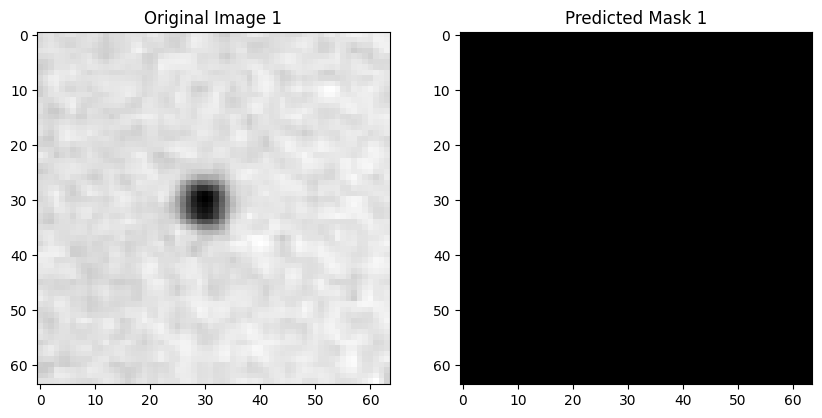

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


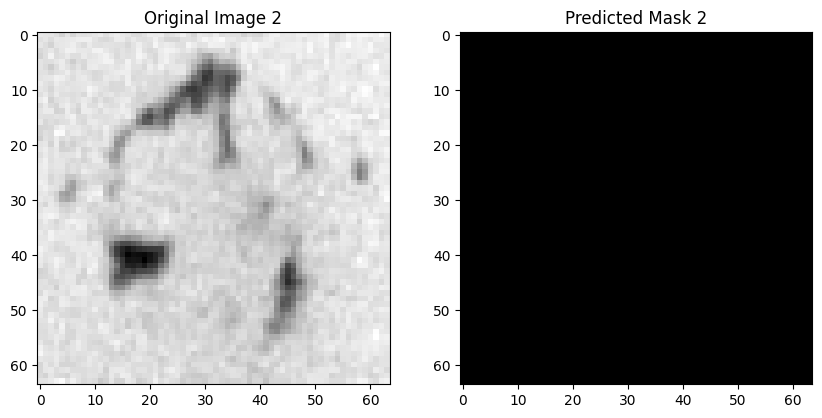

In [79]:
# After training:

# Load sample images
sample_images = load_sample_images(sample_images_folder)
sample_images = sample_images / 255.0  # Normalize


# Predict on sample images
for i, sample_image in enumerate(sample_images):
    predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
    predicted_mask_binary = np.argmax(predicted_mask, axis=-1)



    # Plot the original image and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image {i + 1}")
    plt.imshow(sample_image[:, :, 0], cmap='gray')  # Adjust channel if needed

    plt.subplot(1, 2, 2)
    plt.title(f"Predicted Mask {i + 1}")
    plt.imshow(predicted_mask_binary, cmap='gray')

    plt.show()